In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "Mono"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
COMBAT2022_L028_S00003_T0_AACTCAGTCACCTTAT,COMBAT2022,COMBAT2022_L028,COMBAT2022_S00003_T0,5_GEX_V1,COVID,female,18-30,Mono,Mono_inflammatory
COMBAT2022_L028_S00003_T0_AACTTTCTCCCAACGG,COMBAT2022,COMBAT2022_L028,COMBAT2022_S00003_T0,5_GEX_V1,COVID,female,18-30,Mono,Mono_classical
COMBAT2022_L028_S00003_T0_AAGACCTCAAAGGCGT,COMBAT2022,COMBAT2022_L028,COMBAT2022_S00003_T0,5_GEX_V1,COVID,female,18-30,Mono,Mono_IFNresponse
COMBAT2022_L028_S00003_T0_ACATACGCACAACGTT,COMBAT2022,COMBAT2022_L028,COMBAT2022_S00003_T0,5_GEX_V1,COVID,female,18-30,Mono,Mono_classical
COMBAT2022_L028_S00003_T0_ACGATGTGTCTTGCGG,COMBAT2022,COMBAT2022_L028,COMBAT2022_S00003_T0,5_GEX_V1,COVID,female,18-30,Mono,Mono_inflammatory
...,...,...,...,...,...,...,...,...,...
SCGT00_L039_I013016.3P_T0_TTTAGTCCAACCGTAT,SCGT00,SCGT00_L039,SCGT00_I013016.3P_T0,3_GEX_V3,PS,female,51-60,Mono,Mono_regulatory
SCGT00_L039_I013016.3P_T0_TTTAGTCCAGTGTGGA,SCGT00,SCGT00_L039,SCGT00_I013016.3P_T0,3_GEX_V3,PS,female,51-60,Mono,Mono_regulatory
SCGT00_L039_I013016.3P_T0_TTTGGTTCACACCGAC,SCGT00,SCGT00_L039,SCGT00_I013016.3P_T0,3_GEX_V3,PS,female,51-60,Mono,Mono_classical


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
13,4,1,0.622306,0.437333,0.272155
12,3,4,0.292995,0.980983,0.287423
15,4,3,0.292995,1.000000,0.292995
0,0,1,0.723072,0.437333,0.316223
14,4,2,0.593992,0.554978,0.329652
10,3,1,0.943675,0.437333,0.412700
7,2,1,1.000000,0.437333,0.437333
11,3,2,0.903281,0.554978,0.501301
1,0,2,0.944867,0.554978,0.524380
4,1,2,1.000000,0.554978,0.554978


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

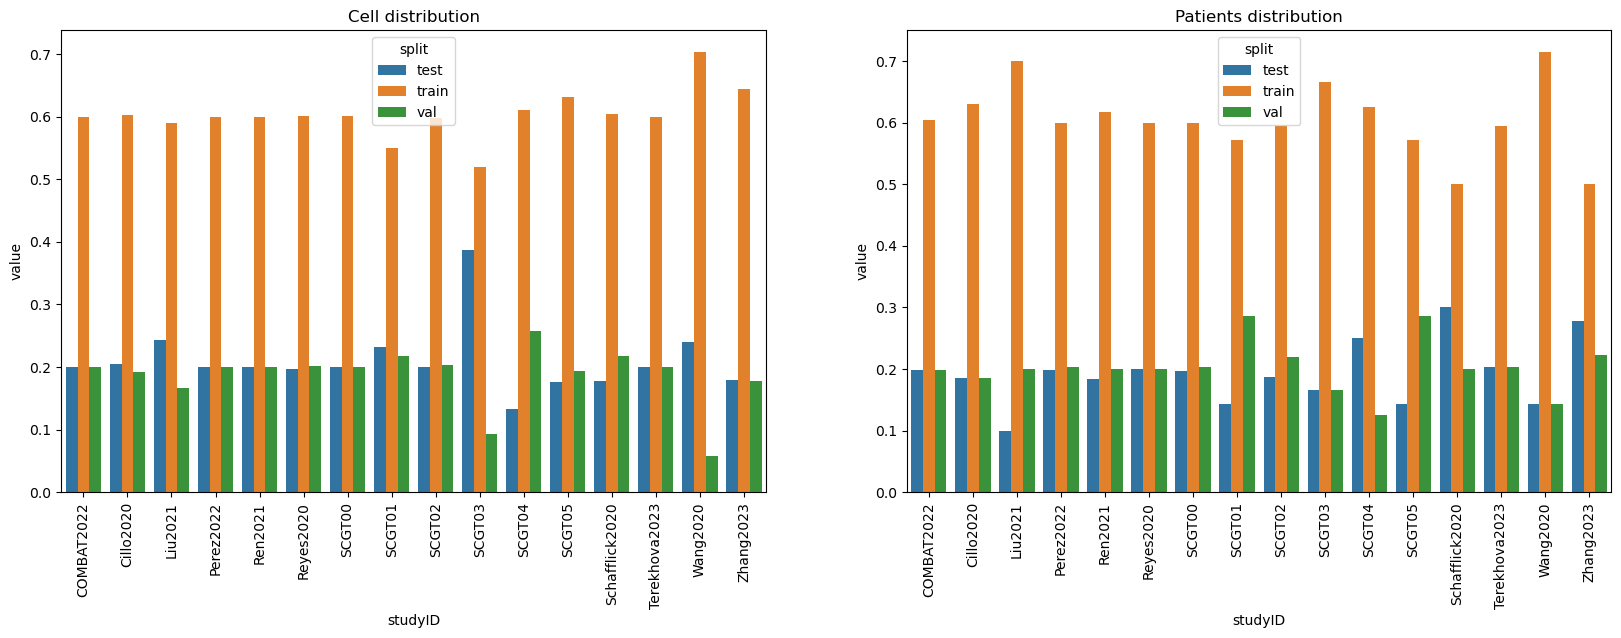

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((630885, 935), (206016, 935), (212248, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((630885,), (206016,), (212248,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-18 18:27:56,553] A new study created in memory with name: no-name-c08bdcaa-a1bf-4cb5-be91-75223454a6cd


/tmp/ipykernel_1754821/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250318_182801-cury0vrz
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_Mono


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/cury0vrz


[I 2025-03-18 18:30:12,752] Trial 0 finished with value: -0.987082 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.987082.


[I 2025-03-18 18:32:18,019] Trial 1 finished with value: -0.994102 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.994102.


[I 2025-03-18 18:44:38,459] Trial 2 finished with value: -0.992692 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.994102.


[I 2025-03-18 18:46:22,587] Trial 3 finished with value: -0.992495 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.994102.


[I 2025-03-18 18:47:01,392] Trial 4 finished with value: -0.994316 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 4 with value: -0.994316.


[I 2025-03-18 18:48:15,953] Trial 5 finished with value: -0.990725 and parameters: {'max_depth': 17, 'min_child_weight': 50, 'subsample': 0.5628109945722505, 'colsample_bynode': 0.6331731119758383, 'learning_rate': 0.0013346527038305934}. Best is trial 4 with value: -0.994316.


[I 2025-03-18 18:48:58,842] Trial 6 finished with value: -0.992264 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 4 with value: -0.994316.


[I 2025-03-18 18:49:12,239] Trial 7 pruned. Trial was pruned at iteration 2.


[I 2025-03-18 18:49:24,821] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:50:05,149] Trial 9 finished with value: -0.990281 and parameters: {'max_depth': 14, 'min_child_weight': 78, 'subsample': 0.5680612190600297, 'colsample_bynode': 0.5920392514089517, 'learning_rate': 0.0031543990308330965}. Best is trial 4 with value: -0.994316.


[I 2025-03-18 18:50:17,693] Trial 10 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:51:01,599] Trial 11 finished with value: -0.994522 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.9785259098721957, 'colsample_bynode': 0.40131565860091256, 'learning_rate': 0.08587379144532957}. Best is trial 11 with value: -0.994522.


[I 2025-03-18 18:52:00,212] Trial 12 finished with value: -0.996629 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.37777201587536535, 'colsample_bynode': 0.36301461895178766, 'learning_rate': 0.14603786032022117}. Best is trial 12 with value: -0.996629.


[I 2025-03-18 18:52:15,327] Trial 13 pruned. Trial was pruned at iteration 4.


[I 2025-03-18 18:52:28,328] Trial 14 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 18:53:01,766] Trial 15 finished with value: -0.99117 and parameters: {'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.706477734046452, 'colsample_bynode': 0.17061614647010237, 'learning_rate': 0.033114226677728044}. Best is trial 12 with value: -0.996629.


[I 2025-03-18 18:53:14,132] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:53:26,534] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:53:39,479] Trial 18 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 18:53:52,229] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:54:04,999] Trial 20 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 18:54:45,847] Trial 21 finished with value: -0.993983 and parameters: {'max_depth': 14, 'min_child_weight': 25, 'subsample': 0.39673994593235895, 'colsample_bynode': 0.5001340293838156, 'learning_rate': 0.016024547718470707}. Best is trial 12 with value: -0.996629.


[I 2025-03-18 18:55:22,104] Trial 22 finished with value: -0.992612 and parameters: {'max_depth': 15, 'min_child_weight': 24, 'subsample': 0.2815194679075228, 'colsample_bynode': 0.43267063684561813, 'learning_rate': 0.02514400729021897}. Best is trial 12 with value: -0.996629.


[I 2025-03-18 18:55:35,953] Trial 23 pruned. Trial was pruned at iteration 2.


[I 2025-03-18 18:55:48,674] Trial 24 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 18:56:26,722] Trial 25 finished with value: -0.995519 and parameters: {'max_depth': 10, 'min_child_weight': 30, 'subsample': 0.37926607312242144, 'colsample_bynode': 0.4119796897092074, 'learning_rate': 0.10160881729898019}. Best is trial 12 with value: -0.996629.


[I 2025-03-18 18:57:37,483] Trial 26 finished with value: -0.994567 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6426028383572815, 'colsample_bynode': 0.522701122786231, 'learning_rate': 0.10028819625485416}. Best is trial 12 with value: -0.996629.


[I 2025-03-18 18:57:49,976] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:58:03,763] Trial 28 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 18:58:16,583] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:58:29,839] Trial 30 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 18:58:43,954] Trial 31 pruned. Trial was pruned at iteration 2.


[I 2025-03-18 18:58:56,811] Trial 32 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 18:59:09,332] Trial 33 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:59:21,956] Trial 34 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:59:33,704] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 18:59:47,322] Trial 36 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 19:00:05,405] Trial 37 pruned. Trial was pruned at iteration 7.


[I 2025-03-18 19:00:18,631] Trial 38 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 19:00:31,476] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 19:00:46,385] Trial 40 pruned. Trial was pruned at iteration 4.


[I 2025-03-18 19:01:00,330] Trial 41 pruned. Trial was pruned at iteration 2.


[I 2025-03-18 19:01:13,815] Trial 42 pruned. Trial was pruned at iteration 1.


[I 2025-03-18 19:01:26,551] Trial 43 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 19:01:38,901] Trial 44 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 19:01:51,281] Trial 45 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 19:02:05,414] Trial 46 pruned. Trial was pruned at iteration 2.


[I 2025-03-18 19:02:40,272] Trial 47 finished with value: -0.994148 and parameters: {'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.45732233824507734, 'colsample_bynode': 0.2705486939074823, 'learning_rate': 0.028369147910903225}. Best is trial 12 with value: -0.996629.


[I 2025-03-18 19:02:52,914] Trial 48 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 19:03:05,258] Trial 49 pruned. Trial was pruned at iteration 0.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_Mono_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:1.69987	validation_0-custom_f1_score:-0.98308


[1]	validation_0-mlogloss:1.34591	validation_0-custom_f1_score:-0.98903


[2]	validation_0-mlogloss:1.10711	validation_0-custom_f1_score:-0.99028


[3]	validation_0-mlogloss:0.92847	validation_0-custom_f1_score:-0.99133


[4]	validation_0-mlogloss:0.78829	validation_0-custom_f1_score:-0.99170


[5]	validation_0-mlogloss:0.67419	validation_0-custom_f1_score:-0.99208


[6]	validation_0-mlogloss:0.57904	validation_0-custom_f1_score:-0.99242


[7]	validation_0-mlogloss:0.49978	validation_0-custom_f1_score:-0.99289


[8]	validation_0-mlogloss:0.43249	validation_0-custom_f1_score:-0.99327


[9]	validation_0-mlogloss:0.37565	validation_0-custom_f1_score:-0.99347


[10]	validation_0-mlogloss:0.32697	validation_0-custom_f1_score:-0.99398


[11]	validation_0-mlogloss:0.28541	validation_0-custom_f1_score:-0.99413


[12]	validation_0-mlogloss:0.24958	validation_0-custom_f1_score:-0.99426


[13]	validation_0-mlogloss:0.21829	validation_0-custom_f1_score:-0.99464


[14]	validation_0-mlogloss:0.19144	validation_0-custom_f1_score:-0.99485


[15]	validation_0-mlogloss:0.16798	validation_0-custom_f1_score:-0.99525


[16]	validation_0-mlogloss:0.14796	validation_0-custom_f1_score:-0.99534


[17]	validation_0-mlogloss:0.13065	validation_0-custom_f1_score:-0.99559


[18]	validation_0-mlogloss:0.11532	validation_0-custom_f1_score:-0.99570


[19]	validation_0-mlogloss:0.10217	validation_0-custom_f1_score:-0.99599


[20]	validation_0-mlogloss:0.09064	validation_0-custom_f1_score:-0.99612


[21]	validation_0-mlogloss:0.08052	validation_0-custom_f1_score:-0.99638


[22]	validation_0-mlogloss:0.07183	validation_0-custom_f1_score:-0.99645


[23]	validation_0-mlogloss:0.06400	validation_0-custom_f1_score:-0.99664


[24]	validation_0-mlogloss:0.05740	validation_0-custom_f1_score:-0.99668


[25]	validation_0-mlogloss:0.05148	validation_0-custom_f1_score:-0.99686


[26]	validation_0-mlogloss:0.04645	validation_0-custom_f1_score:-0.99691


[27]	validation_0-mlogloss:0.04194	validation_0-custom_f1_score:-0.99700


[28]	validation_0-mlogloss:0.03801	validation_0-custom_f1_score:-0.99710


[29]	validation_0-mlogloss:0.03473	validation_0-custom_f1_score:-0.99709


[30]	validation_0-mlogloss:0.03169	validation_0-custom_f1_score:-0.99715


[31]	validation_0-mlogloss:0.02895	validation_0-custom_f1_score:-0.99733


[32]	validation_0-mlogloss:0.02659	validation_0-custom_f1_score:-0.99737


[33]	validation_0-mlogloss:0.02463	validation_0-custom_f1_score:-0.99737


[34]	validation_0-mlogloss:0.02279	validation_0-custom_f1_score:-0.99739


[35]	validation_0-mlogloss:0.02122	validation_0-custom_f1_score:-0.99740


[36]	validation_0-mlogloss:0.01975	validation_0-custom_f1_score:-0.99744


[37]	validation_0-mlogloss:0.01836	validation_0-custom_f1_score:-0.99755


[38]	validation_0-mlogloss:0.01721	validation_0-custom_f1_score:-0.99753


[39]	validation_0-mlogloss:0.01622	validation_0-custom_f1_score:-0.99757


[40]	validation_0-mlogloss:0.01525	validation_0-custom_f1_score:-0.99766


[41]	validation_0-mlogloss:0.01444	validation_0-custom_f1_score:-0.99770


[42]	validation_0-mlogloss:0.01379	validation_0-custom_f1_score:-0.99773


[43]	validation_0-mlogloss:0.01318	validation_0-custom_f1_score:-0.99774


[44]	validation_0-mlogloss:0.01257	validation_0-custom_f1_score:-0.99774


[45]	validation_0-mlogloss:0.01199	validation_0-custom_f1_score:-0.99778


[46]	validation_0-mlogloss:0.01146	validation_0-custom_f1_score:-0.99783


[47]	validation_0-mlogloss:0.01110	validation_0-custom_f1_score:-0.99781


[48]	validation_0-mlogloss:0.01063	validation_0-custom_f1_score:-0.99788


[49]	validation_0-mlogloss:0.01017	validation_0-custom_f1_score:-0.99794


[50]	validation_0-mlogloss:0.00976	validation_0-custom_f1_score:-0.99802


[51]	validation_0-mlogloss:0.00946	validation_0-custom_f1_score:-0.99801


[52]	validation_0-mlogloss:0.00914	validation_0-custom_f1_score:-0.99806


[53]	validation_0-mlogloss:0.00887	validation_0-custom_f1_score:-0.99806


[54]	validation_0-mlogloss:0.00858	validation_0-custom_f1_score:-0.99815


[55]	validation_0-mlogloss:0.00831	validation_0-custom_f1_score:-0.99822


[56]	validation_0-mlogloss:0.00819	validation_0-custom_f1_score:-0.99817


[57]	validation_0-mlogloss:0.00791	validation_0-custom_f1_score:-0.99824


[58]	validation_0-mlogloss:0.00771	validation_0-custom_f1_score:-0.99827


[59]	validation_0-mlogloss:0.00752	validation_0-custom_f1_score:-0.99831


[60]	validation_0-mlogloss:0.00728	validation_0-custom_f1_score:-0.99836


[61]	validation_0-mlogloss:0.00713	validation_0-custom_f1_score:-0.99838


[62]	validation_0-mlogloss:0.00702	validation_0-custom_f1_score:-0.99838


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.36301461895178766,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x77ef07dbf600>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14603786032022117, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=63, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_Mono_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[19:04:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


